### Notebook to assess lagged changes in precip category in TC output, binned according to a 2D variable.

Assumes output is in a single netcdf file on pressure levels.

James Ruppert  
jruppert@ou.edu  
12/18/23

In [10]:
import numpy as np
import matplotlib
import matplotlib.pyplot as plt
import sys
from thermo_functions import *
from precip_class import *
from read_functions import *
from scipy import stats
import pickle

### Main settings

In [11]:
# Number of time steps to sample
t1_test=48 # max of 48
# t1_test=12 # max of 48

storm = 'haiyan'
# storm = 'maria'

# Write out pickle file?
do_write=True
do_write=False

# main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/wrfenkf/"
main = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/tc_ens/"
figdir = "/home/jamesrup/figures/tc/ens/"+storm+'/'
datdir2 = 'post/d02/'
main_pickle = "/ourdisk/hpc/radclouds/auto_archive_notyet/tape_2copies/jruppert/tc_postproc/"+storm+'/'

# pclass_names = ['noncloud','deepc','congest','shallowc','strat','anvil']
pclass_names=["Non-cloud", "Deep", "Cong", "Shallow", "Strat", "Anvil"]
npclass=len(pclass_names)

# Tests to read and compare
if storm == 'haiyan':
    tests = ['ctl','ncrf36h','STRATANVIL_ON','STRATANVIL_OFF','STRAT_OFF']
    tests_str = ['CTL','NCRF','CONVOFF','STRATANVOFF','STRATOFF']
    # tests = ['ctl','ncrf36h']
    # tests_str = ['CTL','NCRF']
    # tests = ['crfon','ncrf']
elif storm == 'maria':
    # tests = ['ctl','ncrf36h']
    tests = ['ctl','ncrf48h']
    tests_str = ['CTL','NCRF']
ntest=len(tests_str)

# Members
nmem = 10 # number of ensemble members (1-5 have NCRF)
# nmem = 2

In [12]:
# Ensemble member info
memb0=1 # Starting member to read
memb_nums=np.arange(memb0,nmem+memb0,1)
memb_nums_str=memb_nums.astype(str)
nustr = np.char.zfill(memb_nums_str, 2)
memb_all=np.char.add('memb_',nustr)

# Get dimensions
datdir = main+storm+'/'+memb_all[0]+'/'+tests[0]+'/'+datdir2
nt_data, nz, nx1, nx2, pres = get_file_dims(datdir)
nx1-=80*2
nx2-=80*2

### Main loops and compositing

In [13]:
# Main read loops for 3D (dependent) variables

nt=t1_test

npts = nx1*nx2

# Arrays to save variables
dims = (ntest, nmem, nt, nx1, nx2)
pclass_all = np.zeros(dims)
dims_area = (ntest, nmem, nt, npclass)
pclass_area = np.zeros(dims_area)

for itest in range(ntest):

    test_str=tests_str[itest]
    test_read=tests[itest]
    print('Running test: ',test_str)

    if test_read == 'ctl':
        t0=36
        # t1=t0+49
        # Control test time sample
        t1=t0+t1_test
    else:
        t0=0
        # t1=49 # max
        # Control test time sample
        t1=t1_test

    # Loop over ensemble members

    for imemb in range(nmem):

        datdir = main+storm+'/'+memb_all[imemb]+'/'+test_read+'/'+datdir2
        pickle_file = main_pickle+memb_all[imemb]+'/pclass_'+test_read+'_'+str(t1_test)+'hrs.pkl'

        if do_write:

            # PCLASS index
            q_int = read_qcloud(datdir, t0, t1, mask=True, drop=True) # mm
            pclass_all[itest,imemb,:,:,:] = precip_class(q_int)

            for it in range(nt):
                for ipclass in range(npclass):
                    indices = (pclass_all[itest,imemb,it,...] == ipclass).nonzero()
                    pclass_area[itest,imemb,it,ipclass] = indices[0].shape[0]/npts

            with open(pickle_file, 'wb') as file:
                pickle.dump([pclass_all[itest,imemb,...], pclass_area[itest,imemb,...]], file)

        else:

            with open(pickle_file, 'rb') as file:
                ipclass, ipclass_area = pickle.load(file)
            pclass_all[itest,imemb,...]  = ipclass
            pclass_area[itest,imemb,...] = ipclass_area

Running test:  CTL
Running test:  NCRF
Running test:  CONVOFF
Running test:  STRATANVOFF
Running test:  STRATOFF


In [14]:
# P-class tendency
print(pclass_all.shape)
nddt=6 # n-time steps to diagnose lead changes
dims_area = (ntest, nmem, npclass, nt-nddt, nddt)
pclass_ddt = np.zeros(dims_area)
for itest in range(ntest):
    for imemb in range(nmem):
        # ivar = pclass_all[itest,imemb,it,...]
        ivar = pclass_all[itest,imemb,...]
        for it in range(nt-nddt):
            for ipclass in range(npclass):
                for iddt in range(nddt):
                    indices = (ivar == ipclass).nonzero()
                    pclass_ddt[itest,imemb,ipclass,it,iddt] = indices[0].shape[0]

---
### Plotting routines

In [15]:
font = {'family' : 'sans-serif',
        'weight' : 'normal',
        'size'   : 12}

matplotlib.rc('font', **font)

### PClass area time series

In [16]:
# Confidence interval using T-test and assuming 95% significance
def mean_confidence_interval(data):
    # conf_set=0.95 # Confidence interval to apply throughout
    conf_set=0.9 # Confidence interval to apply throughout
    a = 1.0 * np.array(data)
    # n = len(a)
    n = a.shape[0]
    m, se = np.mean(a, axis=0), stats.sem(a, axis=0)
    # num = stats.t.ppf((1 + conf_set) / 2., n-1)
    h = se * stats.t.ppf((1 + conf_set) / 2., n-1)
    return m, m-h, m+h

In [17]:
# Smooth time series
# Assumes f = f(nmem, nt), smooths only over 2nd dimension
def smooth_tser(invar):
    invar_sm = np.copy(invar)
    invar_sm[:,1:-1] = (invar_sm[:,2:] + invar_sm[:,1:-1] + invar_sm[:,0:-2])/3
    return invar_sm

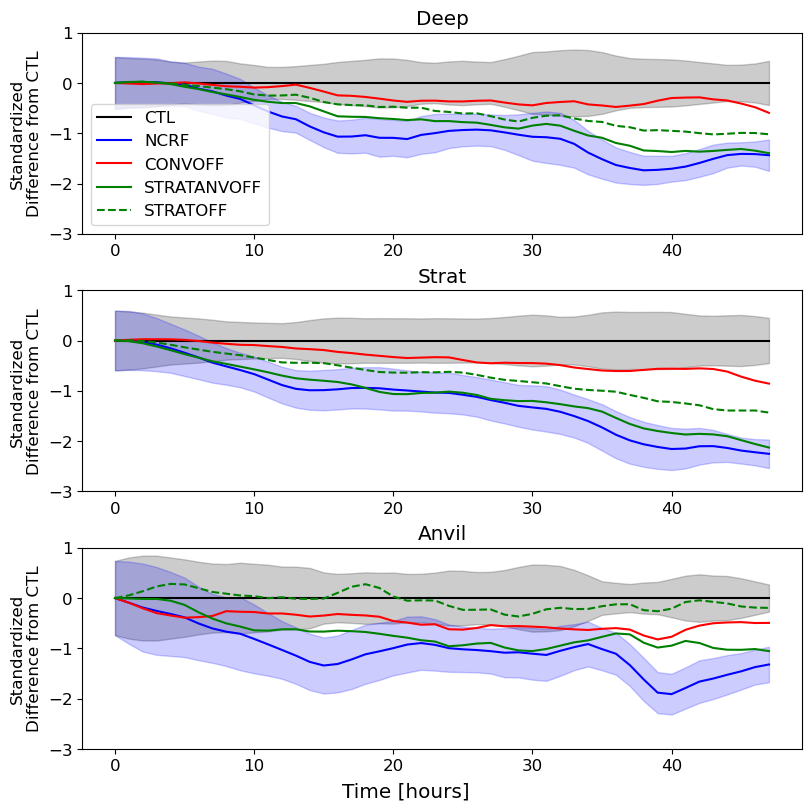

In [18]:
xmax=nt
# xmax=12

# XX Average ensemble members
# pltvar = np.mean(pclass_area, axis=1)
pltvar = np.copy(pclass_area)

# As difference from CTL-ens-mean
ctl=np.mean(pltvar[0], axis=0)
pltvar_anom = pltvar - ctl[np.newaxis,np.newaxis,...]

# XX Normalize by mean for each pclass
# Standardize using STD from all pclass, ensemble members
stddev = np.std(pltvar,axis=(0,1,2))
stddev_ctl = np.std(pltvar[0],axis=(0,1))
# pltvar_anom = pltvar_anom/stddev[np.newaxis,np.newaxis,np.newaxis,:]
pltvar_anom = pltvar_anom/stddev_ctl[np.newaxis,np.newaxis,np.newaxis,:]

linecolor=['black', 'blue', 'red', 'green', 'green']
linestyle=['solid']*ntest # this creates an array of ['solid'] of size ntest
linestyle[-1]='dashed'

# create figure

# ipclass_plot=np.arange(npclass)
# ipclass_plot=[1,2,3,4,5]
ipclass_plot=[1,4,5]
npclass_plot=len(ipclass_plot)

fig_x = 8
# fig_y = 14
fig_y = 8
fig, ax = plt.subplots(npclass_plot,1, figsize=(fig_x,fig_y), layout="constrained",) # row, column

fig.supxlabel('Time [hours]')

for ipclass in range(npclass_plot):

        ipclass_data=ipclass_plot[ipclass]

        # create figure
        # fig = plt.figure(figsize=(14,4))
        # ax = fig.add_subplot(111)

        fig_title = pclass_names[ipclass_data]
        ax[ipclass].set_title(fig_title)

        # ylabel='Area fraction [%]'
        ylabel='Standardized\nDifference from CTL'

        for itest in range(ntest):
                ipvar=pltvar_anom[itest,:,:,ipclass_data]
                ipvar_sm = smooth_tser(ipvar)
                # ipvar_sm = np.copy(ipvar)
                mean, low, high = mean_confidence_interval(ipvar_sm)
                ax[ipclass].plot(mean[:xmax], label=tests_str[itest],
                         color=linecolor[itest], linestyle=linestyle[itest])
                if itest <= 1:
                        ax[ipclass].fill_between(np.arange(xmax), high[:xmax], low[:xmax], alpha=0.2, color=linecolor[itest])
                ax[ipclass].set_ylim(-3,1)

        ax[ipclass].set_ylabel(ylabel)

# if ipclass == 0:
ax[0].legend(loc="lower left")

#     plt.savefig(figdir+'binnedcross_convstrat_ens'+enstag+'m_'+ivar_select+'_'+test_str+'.png',dpi=200, facecolor='white', \
#                 bbox_inches='tight', pad_inches=0.2)
plt.show()
plt.close()